# NDSC_beginner_LSTM_withColab
_run custom Glove with train.csv first before this_

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
import math
from tqdm import tqdm
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
train_df = pd.read_csv("train.csv")
train_df = train_df.sample(frac=1.)
val_df = train_df[:1000]
train_df = train_df[1000:]
val_df.head()

,itemid,title,Category,image_path
651244,1088744053,samsung note 5 dual sim 32gb gold normal aman ...,32,mobile_image/49410ad651a55f2fd90175453263cff8.jpg
379280,238072487,dress pensil o neck lengan pendek desain patch...,22,fashion_image/9290eca02841b760bd0d74a3683195aa
480167,1537988006,kaos t shirt wanita lengan pendek model longga...,25,fashion_image/0e93a56abef8cb89a8741e0ce4774766
167687,1526508992,theraskin niacin cream,4,beauty_image/e99c45f60dedb31058efbdc441df601d.jpg
209732,1317982331,bioaqua 5in1 concealer bb cream mascara lipsti...,5,beauty_image/2c713f40dbec7d5602cc26dd52a345e1.jpg


In [5]:
val_df.shape

(1000, 4)

In [6]:
train_df.shape

(665615, 4)

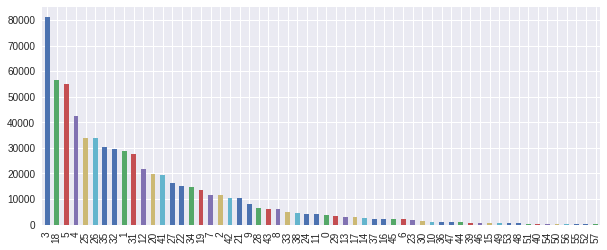

In [7]:
plt.figure(figsize=(10,4))
train_df.Category.value_counts().plot(kind='bar');

In [8]:
# Embdedding setup, save it in a dictionary for easier queries
embeddings_index = {}
f = open('custom_glove_100d.txt')
for line in tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

16690it [00:00, 29936.69it/s]

Found 16690 word vectors.


In [0]:
# Convert values to embeddings
def text_to_array(text):
    empyt_emb = np.zeros(100)
    text = text[:-1].split()[:100]
    embeds = [embeddings_index.get(x, empyt_emb) for x in text]
    embeds+= [empyt_emb] * (100 - len(embeds))
    return np.array(embeds)

In [0]:
val_vects = np.array([text_to_array(X_text) for X_text in (val_df["title"][:])])
val_y_labels = np.array(val_df["Category"])
# val_y = np.zeros((len(val_y_labels), 58))
# val_y[np.arange(len(val_y_labels)), val_y_labels] = 1

In [11]:
# Understand what a batch is made of
batch_size = 128
i = 0
texts = train_df.iloc[i*batch_size:(i+1)*batch_size, 1]
text_arr = np.array([text_to_array(text) for text in texts])
batch_labels = np.array(train_df["Category"][i*batch_size:(i+1)*batch_size])
batch_targets = np.zeros((batch_size, 58))
batch_targets[np.arange(batch_size), batch_labels] = 1
print(np.shape(text_arr))
print(np.shape(batch_targets))
print(text_arr)
print(batch_targets)

(128, 100, 100)
(128, 58)
[[[-0.09847451  0.6330533   0.15802506 ... -0.43873549 -0.59449768
   -0.49114525]
  [ 0.31039712  0.51801658 -0.35143414 ...  0.16992922  0.15494995
   -0.03809067]
  [ 0.01175395  0.60735446 -0.44130594 ...  0.42869753  0.39359817
   -0.44444847]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.25342065  0.41580129  0.0435044  ...  0.07893132 -0.36673653
   -0.72164488]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.25013015 -0.1022802 

In [0]:
# Write generator, which 
batch_size = 128

def batch_gen(train_df):
    n_batches = math.floor(len(train_df) / batch_size)
    while True: 
        train_df = train_df.sample(frac=1.)  # Shuffle the data.
        for i in range(n_batches):
            texts = train_df.iloc[i*batch_size:(i+1)*batch_size, 1]
            text_arr = np.array([text_to_array(text) for text in texts])
            batch_labels = np.array(train_df["Category"][i*batch_size:(i+1)*batch_size])
            yield text_arr, batch_labels

# Training

In [13]:
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Bidirectional, Activation, Dropout

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history["loss"], color="purple")
    plt.plot(history.history["acc"], color="blue")
    plt.plot(history.history["val_loss"], color="red")
    plt.plot(history.history["val_acc"], color="green")
    plt.xlim(0,)
    plt.ylim(0.5,1.5)
    plt.legend(['loss', 'acc', "val_loss", "val_acc"], loc='upper right')
    plt.show()

In [15]:
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True),
                        input_shape=(100, 100)))
model.add(Dropout(0.05))
model.add(Bidirectional(CuDNNLSTM(128)))
model.add(Dense(58))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100, 256)          235520    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               395264    
_________________________________________________________________
dense_1 (Dense)              (None, 58)                14906     
_________________________________________________________________
activation_1 (Activation)    (None, 58)                0         
Total params: 645,690
Trainable params: 645,690
Non-trainable params: 0
_________________________________________________________________


In [17]:
mg = batch_gen(train_df)
history = model.fit_generator(mg, epochs=90,
                    steps_per_epoch=1000,
                    validation_data=(val_vects, val_y_labels),
                    verbose=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/90
1000/1000 [==============================] - 118s 118ms/step - loss: 1.3204 - acc: 0.6060 - val_loss: 1.0566 - val_acc: 0.6750
Epoch 2/90
1000/1000 [==============================] - 116s 116ms/step - loss: 1.0705 - acc: 0.6708 - val_loss: 1.0187 - val_acc: 0.6800
Epoch 3/90
1000/1000 [==============================] - 115s 115ms/step - loss: 1.0167 - acc: 0.6842 - val_loss: 0.9867 - val_acc: 0.6980
Epoch 4/90
1000/1000 [==============================] - 115s 115ms/step - loss: 0.9978 - acc: 0.6891 - val_loss: 0.9464 - val_acc: 0.7120
Epoch 5/90
1000/1000 [==============================] - 115s 115ms/step - loss: 0.9851 - acc: 0.6906 - val_loss: 0.9513 - val_acc: 0.7000
Epoch 6/90
1000/1000 [==============================] - 115s 115ms/step - loss: 0.9616 - acc: 0.6965 - val_loss: 0.9444 - val_acc: 0.7030
Epoch 7/90
1000/1000 [==============================] - 115s 115ms/step - loss: 0.9492 - acc: 0.7000 - val_loss: 0.9243 - va

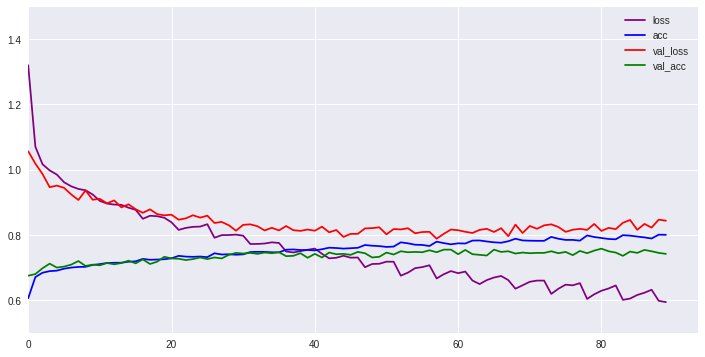

In [18]:
plot_history(history)

In [19]:
history = model.fit_generator(mg, epochs=1,
                    steps_per_epoch=1000,
                    validation_data=(val_vects, val_y_labels),
                    verbose=True)

Epoch 1/1
1000/1000 [==============================] - 115s 115ms/step - loss: 0.6028 - acc: 0.7984 - val_loss: 0.8307 - val_acc: 0.7430


# Inference

In [21]:
# Make the prediction from the model
batch_size = 256
def batch_gen(test_df):
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        texts = test_df.iloc[i*batch_size:(i+1)*batch_size, 1]
        text_arr = np.array([text_to_array(text) for text in texts])
        yield text_arr

test_df = pd.read_csv("test.csv")
test_df["Supercategory"] = test_df["image_path"].str[0]
supercats = np.array(test_df["Supercategory"])
supercat_dict = {
    "b" : np.array([1]*17 + [0]*14 + [0]*27),
    "f" : np.array([0]*17 + [1]*14 + [0]*27),
    "m" : np.array([0]*17 + [0]*14 + [1]*27)
}

all_preds = []
for x in tqdm(batch_gen(test_df)):
    all_preds.extend(model.predict(x))

674it [03:31,  3.71it/s]


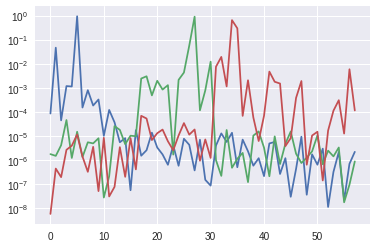

In [22]:
import matplotlib.pyplot as plt
plt.plot(all_preds[0])
plt.plot(all_preds[int(len(all_preds)/2)])
plt.plot(all_preds[-1])
plt.yscale("log")
plt.show()

In [23]:
print(np.shape(all_preds))
y_te = [np.argmax(pred) for pred,supercat in zip(all_preds,supercats)]

(172402, 58)


In [0]:
submit_df = pd.DataFrame({"itemid": test_df["itemid"], "Category": y_te})
submit_df.to_csv("submission.csv", index=False)

In [25]:
submit_df.head()

,Category,itemid
0,5,370855998
1,5,637234604
2,5,690282890
3,4,930913462
4,5,1039280071


In [26]:
submit_df.shape

(172402, 2)